In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [25]:
class EnhancedTripleBarrierBacktest:
    def __init__(self, 
                 symbol, 
                 start_date, 
                 end_date, 
                 portfolio_value=1000000,
                 upper_barrier=3, 
                 lower_barrier=6, 
                 vertical_barrier_days=10,
                 volatility_window=20,
                 kelly_fraction=0.25,
                 position_size_limit=0.1):  # Max 10% of portfolio per trade
        
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.portfolio_value = portfolio_value
        self.upper_barrier = upper_barrier
        self.lower_barrier = lower_barrier
        self.vertical_barrier_days = vertical_barrier_days
        self.volatility_window = volatility_window
        self.kelly_fraction = kelly_fraction
        self.position_size_limit = position_size_limit
        self.trades = []
        self.equity_curve = []
        
    def fetch_data(self):
        """Fetch and prepare data with features"""
        self.data = yf.download(self.symbol, 
                              start=self.start_date, 
                              end=self.end_date)
        
        # Calculate volatility
        self.data['Returns'] = self.data['Close'].pct_change()
        self.data['Volatility'] = self.data['Returns'].rolling(window=self.volatility_window).std()
        
        # Add basic features for ML
        self.data['MA5'] = self.data['Close'].rolling(window=5).mean()
        self.data['MA20'] = self.data['Close'].rolling(window=20).mean()
        self.data['MA_Ratio'] = self.data['MA5'] / self.data['MA20']
        
        # Add lagged features
        for lag in [1, 2, 3, 5]:
            self.data[f'Returns_Lag_{lag}'] = self.data['Returns'].shift(lag)
            self.data[f'MA_Ratio_Lag_{lag}'] = self.data['MA_Ratio'].shift(lag)
        
        self.data = self.data.dropna()
        return self.data
    
    def calculate_position_size(self, price, volatility):
        """Calculate position size using volatility and Kelly fraction"""
        # Basic Kelly calculation (win_rate * (win_loss_ratio) - (1 - win_rate))
        if not self.trades:  # If no trades yet, use default size
            kelly_size = self.position_size_limit
        else:
            trades_df = pd.DataFrame(self.trades)
            win_rate = len(trades_df[trades_df['return'] > 0]) / len(trades_df)
            avg_win = trades_df[trades_df['return'] > 0]['return'].mean()
            avg_loss = abs(trades_df[trades_df['return'] < 0]['return'].mean())
            
            if avg_loss == 0:  # Avoid division by zero
                kelly_size = self.position_size_limit
            else:
                win_loss_ratio = avg_win / avg_loss
                kelly_size = (win_rate * win_loss_ratio - (1 - win_rate)) * self.kelly_fraction
        
        # Adjust for volatility
        vol_adjusted_size = kelly_size * (0.02 / volatility)  # Target 2% daily vol
        
        # Apply position size limits
        final_size = min(vol_adjusted_size, self.position_size_limit)
        final_size = max(final_size, 0.01)  # Minimum 1% position
        
        # Convert to number of shares
        position_value = self.portfolio_value * final_size
        shares = position_value // price
        
        return shares
    
    def vectorized_barrier_touch(self, prices, upper_barrier, lower_barrier):
        """Vectorized implementation of barrier touch detection"""
        touch_upper = prices >= upper_barrier
        touch_lower = prices <= lower_barrier
        
        if touch_upper.any():
            return 'profit', touch_upper.idxmax()
        elif touch_lower.any():
            return 'loss', touch_lower.idxmax()
        return 'time_decay', prices.index[-1]
    
    def simulate_trades(self):
        """Run the trading simulation with vectorized calculations"""
        portfolio_value = self.portfolio_value
        trades = []
        equity_curve = [portfolio_value]
        
        for entry_date, row in self.data.iterrows():
            entry_price = row['Close']
            volatility = row['Volatility']
            
            # Calculate position size
            shares = self.calculate_position_size(entry_price, volatility)
            position_value = shares * entry_price
            
            upper_target = entry_price + self.upper_barrier
            lower_target = entry_price - self.lower_barrier
            
            # Get forward data
            exit_date = entry_date + pd.Timedelta(days=self.vertical_barrier_days)
            mask = (self.data.index > entry_date) & (self.data.index <= exit_date)
            forward_data = self.data[mask]
            
            if len(forward_data) == 0:
                continue
            
            # Vectorized barrier check
            outcome, exit_date = self.vectorized_barrier_touch(
                forward_data['Close'],
                upper_target,
                lower_target
            )
            
            exit_price = forward_data.loc[exit_date, 'Close']
            trade_return = (exit_price - entry_price) / entry_price
            trade_pnl = position_value * trade_return
            
            portfolio_value += trade_pnl
            equity_curve.append(portfolio_value)
            
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'shares': shares,
                'position_value': position_value,
                'return': trade_return,
                'pnl': trade_pnl,
                'portfolio_value': portfolio_value,
                'outcome': outcome
            })
        
        self.trades = trades
        self.equity_curve = equity_curve
    
    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        trades_df = pd.DataFrame(self.trades)
        returns = trades_df['return']
        pnl = trades_df['pnl']
        
        # Basic metrics
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['return'] > 0])
        win_rate = winning_trades / total_trades
        
        # Risk metrics
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
        sortino_ratio = np.sqrt(252) * (returns.mean() / returns[returns < 0].std())
        
        # Calculate Calmar Ratio
        equity_series = pd.Series(self.equity_curve)
        running_max = equity_series.expanding().max()
        drawdowns = (equity_series - running_max) / running_max
        max_drawdown = drawdowns.min()
        
        annual_return = (self.equity_curve[-1] / self.equity_curve[0]) - 1
        calmar_ratio = annual_return / abs(max_drawdown)
        
        metrics = {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'win_rate': win_rate,
            'avg_return': returns.mean(),
            'cumulative_return': (self.equity_curve[-1] / self.equity_curve[0]) - 1,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'total_pnl': pnl.sum(),
            'avg_position_size': trades_df['position_value'].mean(),
            'final_portfolio_value': self.equity_curve[-1]
        }
        
        return metrics
    
    def plot_results(self):
        """Create comprehensive visualization of results"""
        trades_df = pd.DataFrame(self.trades)
        
        # Create figure with subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
        
        # Plot 1: Equity Curve
        equity_series = pd.Series(self.equity_curve)
        ax1.plot(equity_series)
        ax1.set_title('Portfolio Equity Curve')
        ax1.grid(True)
        
        # Plot 2: Trade Returns Distribution
        sns.histplot(trades_df['return'], ax=ax2, bins=50)
        ax2.set_title('Trade Returns Distribution')
        ax2.grid(True)
        
        # Plot 3: Position Sizes Over Time
        ax3.plot(trades_df['entry_date'], trades_df['position_value'])
        ax3.set_title('Position Sizes Over Time')
        ax3.grid(True)
        
        plt.tight_layout()
        return fig
    
    def run_walkforward_analysis(self, n_splits=5):
        """Perform walk-forward analysis"""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        walkforward_results = []
        
        for train_idx, test_idx in tscv.split(self.data):
            # Split data
            train_data = self.data.iloc[train_idx]
            test_data = self.data.iloc[test_idx]
            
            # Run backtest on test period
            test_start = test_data.index[0]
            test_end = test_data.index[-1]
            
            backtest = EnhancedTripleBarrierBacktest(
                self.symbol,
                test_start,
                test_end,
                self.portfolio_value,
                self.upper_barrier,
                self.lower_barrier,
                self.vertical_barrier_days,
                self.volatility_window,
                self.kelly_fraction
            )
            
            backtest.data = test_data  # Use existing data
            backtest.simulate_trades()
            metrics = backtest.calculate_metrics()
            
            walkforward_results.append({
                'period': f"{test_start.date()} to {test_end.date()}",
                'sharpe': metrics['sharpe_ratio'],
                'returns': metrics['cumulative_return'],
                'max_drawdown': metrics['max_drawdown']
            })
            
        return pd.DataFrame(walkforward_results)

    def run_backtest(self):
        """Run the complete backtest"""
        self.fetch_data()
        self.simulate_trades()
        metrics = self.calculate_metrics()
        walkforward_results = self.run_walkforward_analysis()
        return metrics, walkforward_results



[*********************100%%**********************]  1 of 1 completed



Backtest Results:
Total Trades: 3685
Win Rate: 70.01%
Cumulative Return: 208.23%
Sharpe Ratio: 3.57
Calmar Ratio: 13.55
Max Drawdown: -15.36%
Final Portfolio Value: $3,082,339.43

Walk-Forward Analysis Results:
                     period    sharpe   returns  max_drawdown
0  2012-07-18 to 2014-12-24  5.285881  0.451582     -0.057816
1  2014-12-26 to 2017-06-05  2.258805  0.199173     -0.115327
2  2017-06-06 to 2019-11-11  2.865406  0.276882     -0.085465
3  2019-11-12 to 2022-04-20  5.479181  0.437913     -0.062298
4  2022-04-21 to 2024-09-30  5.360468  0.399157     -0.043371


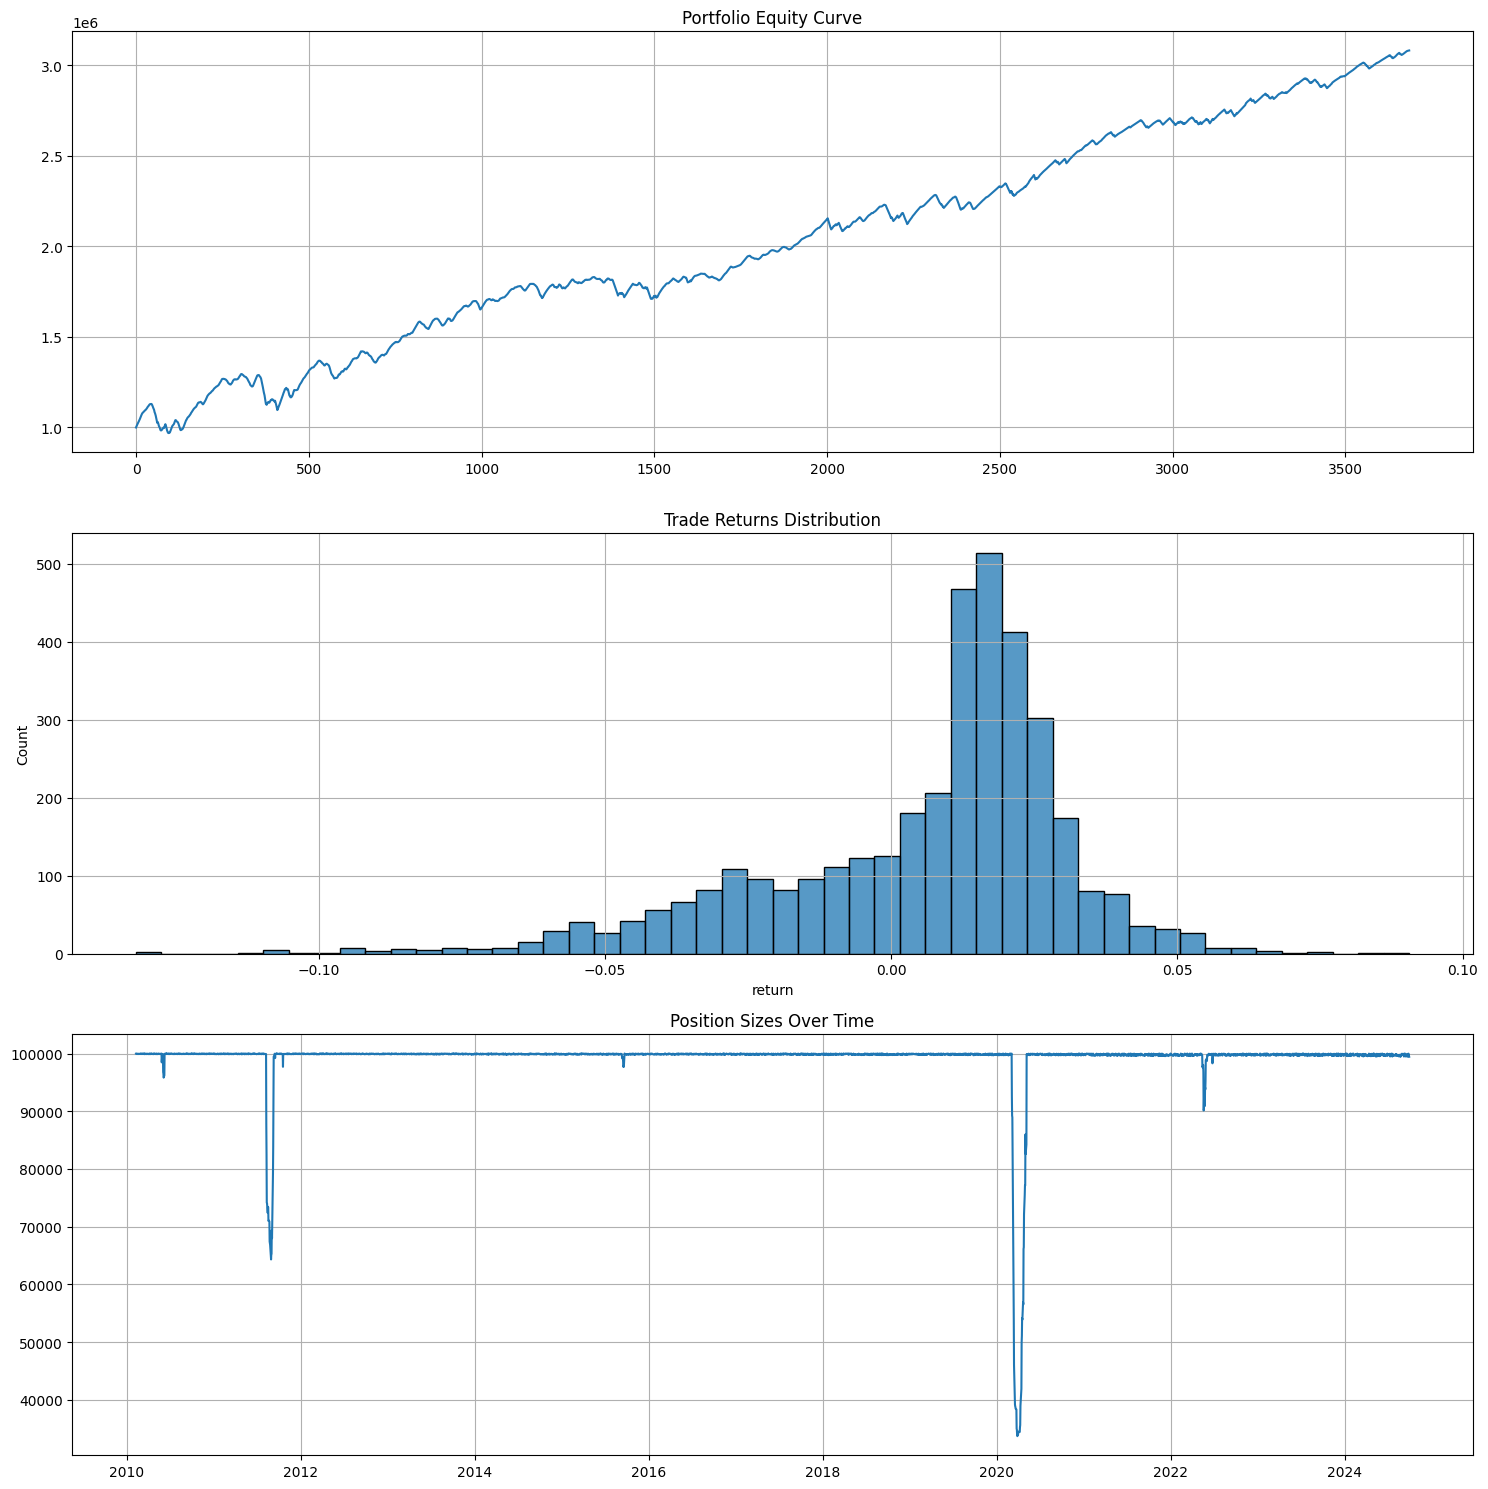

In [24]:
# Example usage
if __name__ == "__main__":
    backtest = EnhancedTripleBarrierBacktest(
        symbol='SPY',
        start_date='2010-01-01',
        end_date='2024-10-01',
        portfolio_value=1000000,
        upper_barrier=5,
        lower_barrier=10,
        vertical_barrier_days=20,
        kelly_fraction=2
    )
    
    metrics, walkforward_results = backtest.run_backtest()
    
    print("\nBacktest Results:")
    print(f"Total Trades: {metrics['total_trades']}")
    print(f"Win Rate: {metrics['win_rate']:.2%}")
    print(f"Cumulative Return: {metrics['cumulative_return']:.2%}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Calmar Ratio: {metrics['calmar_ratio']:.2f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
    print(f"Final Portfolio Value: ${metrics['final_portfolio_value']:,.2f}")
    
    print("\nWalk-Forward Analysis Results:")
    print(walkforward_results)
    
    # Plot results
    backtest.plot_results()
    plt.show()